In [1]:
# Read google drive file
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Objective : The purpose of the modelling is to build the Non-Parametric Regression model.

- As most Tree models will outperform the linear models so using both the pre-feature selected dataset and post-feature selected dataset to measure the model predictability

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
!pip install category_encoders
import category_encoders as ce
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Feature Selected Data

In [4]:
df_baseline_model = pd.read_csv('/content/gdrive/MyDrive/Project - Real Estate/gurgaon_properties_post_feature_selection.csv') #

In [5]:
df_baseline_model.head()

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,floor_category,price
0,0.0,101.0,2.0,1.0,0.0,3.0,500.0,0.0,0.0,0.0,0.0,0.30
1,0.0,91.0,2.0,2.0,4.0,3.0,1465.0,0.0,0.0,0.0,2.0,1.31
2,1.0,53.0,4.0,4.0,3.0,0.0,1440.0,1.0,0.0,2.0,2.0,3.75
3,0.0,36.0,3.0,3.0,3.0,3.0,1707.0,0.0,0.0,0.0,0.0,1.49
4,0.0,87.0,4.0,4.0,3.0,3.0,2000.0,1.0,0.0,0.0,2.0,1.42


In [6]:
df_baseline_model['furnishing_type'].value_counts()

0.0    2426
2.0    1030
1.0     195
Name: furnishing_type, dtype: int64

In [7]:
df_baseline_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3651 entries, 0 to 3650
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_type    3651 non-null   float64
 1   sector           3651 non-null   float64
 2   bedRoom          3651 non-null   float64
 3   bathroom         3651 non-null   float64
 4   balcony          3651 non-null   float64
 5   agePossession    3651 non-null   float64
 6   built_up_area    3651 non-null   float64
 7   servant room     3651 non-null   float64
 8   store room       3651 non-null   float64
 9   furnishing_type  3651 non-null   float64
 10  floor_category   3651 non-null   float64
 11  price            3651 non-null   float64
dtypes: float64(12)
memory usage: 342.4 KB


In [8]:
X = df_baseline_model.drop(columns=['price'])
y = df_baseline_model['price']

<ipython-input-9-0f415a98584e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: xlabel='price', ylabel='Density'>

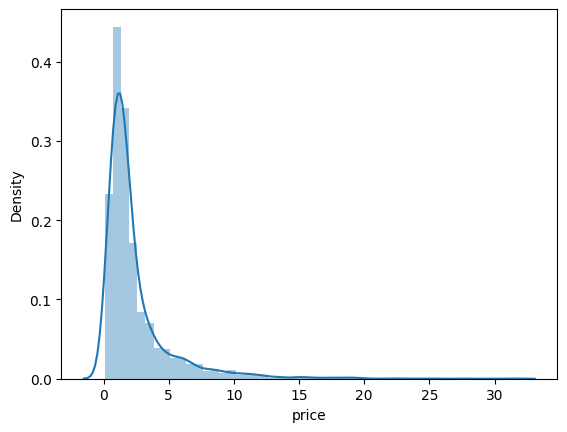

In [9]:
sns.distplot(y)

In [10]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

<ipython-input-11-aa92e888da11>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_transformed)


<Axes: xlabel='price', ylabel='Density'>

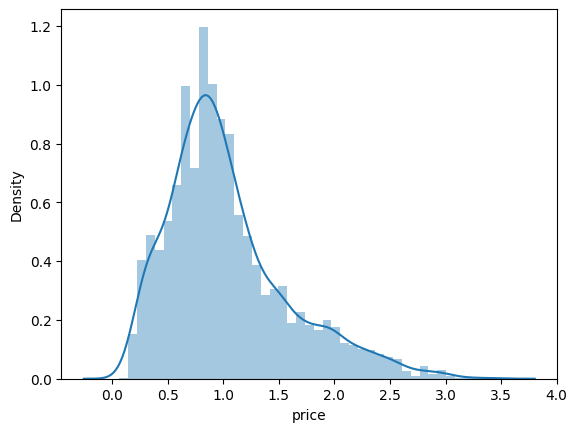

In [11]:
sns.distplot(y_transformed)

In [12]:
# Split the train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2920, 11), (731, 11), (2920,), (731,))

In [14]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom','bathroom','balcony', 'agePossession', 'built_up_area']),
        ('cat',OneHotEncoder(drop='first'),['sector','furnishing_type','floor_category'])
    ],
    remainder='passthrough'
)

In [15]:
# Define a function for training and scoring a model

def train_and_score_model(model, X_train, y_train):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_train = np.expm1(y_pred_train)
    y_train = np.expm1(y_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    return pipeline, scores.mean(), mae_train

In [16]:
# Define a function for testing and scoring a model

def test_and_score_model(model, pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2

In [17]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'MLP': MLPRegressor(),
    'XGBoost': XGBRegressor()
}

In [18]:
# Train and test each model
results = []
for name, model in models.items():
    pipeline, train_score, train_mae = train_and_score_model(model, X_train, y_train)
    mae, test_score = test_and_score_model(model, pipeline, X_test, y_test)
    results.append([name, train_score, train_mae, test_score, mae])

In [19]:
# Display results
columns = ['Model', 'Train R2', 'Train MAE', 'Test R2', 'Test MAE']
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

                Model  Train R2  Train MAE   Test R2  Test MAE
0   Linear Regression  0.848052   0.621317  0.671655  0.604684
1                 SVR  0.879802   0.331224  0.799139  0.478291
2               Ridge  0.848731   0.626736  0.673366  0.604351
3               Lasso -0.004127   1.541584 -0.034589  1.435635
4       Decision Tree  0.801633   0.004610  0.594962  0.639845
5       Random Forest  0.875867   0.202591  0.806548  0.499557
6         Extra Trees  0.887736   0.004610  0.805681  0.463717
7   Gradient Boosting  0.856745   0.543772  0.826900  0.559439
8            AdaBoost  0.732417   0.842014  0.675471  0.830777
9                 MLP  0.887711   0.211480  0.777132  0.474976
10            XGBoost  0.885674   0.241934  0.825858  0.460728


Insight:

On pre-feature selected dataset we observe that the base XGboost model has outperformed other ML models with R2 score 84% and Mean Absolute Error of 0.44 on the test data set

**Non Feature Selected Data**

In [20]:
df_new = pd.read_csv('/content/gdrive/MyDrive/Project - Real Estate/pre_encoding_gurgaon_properties_post_feature_selection.csv')

In [21]:
df_new.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,floor_category
0,flat,sector 99a,0.30,2.0,1.0,0,Relatively New,500.0,0.0,0.0,0.0,0.0,0.0,0.0,High Floor
1,flat,sector 88a,1.31,2.0,2.0,3+,Relatively New,1465.0,1.0,0.0,0.0,0.0,0.0,0.0,Mid Floor
2,house,sector 54,3.75,4.0,4.0,3,Moderately Old,1440.0,0.0,1.0,0.0,0.0,0.0,2.0,Mid Floor
3,flat,sector 37d,1.49,3.0,3.0,3,Relatively New,1707.0,0.0,0.0,0.0,0.0,1.0,0.0,High Floor
4,flat,sector 83,1.42,4.0,4.0,3,Relatively New,2000.0,1.0,1.0,0.0,0.0,0.0,0.0,Mid Floor


In [22]:
df_new.drop(['others'],inplace=True,axis=1) # dropping the others column as it  won't provide much inferenace

In [23]:
# Define a dictionary mapping old column names to new column names
column_renaming = {'study room': 'study_room', 'servant room': 'servant_room', 'store room': 'store_room', 'pooja room': 'pooja_room'}

# Use the rename() function to replace column names
df_new.rename(columns=column_renaming, inplace=True)

df_new.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,study_room,servant_room,store_room,pooja_room,furnishing_type,floor_category
0,flat,sector 99a,0.30,2.0,1.0,0,Relatively New,500.0,0.0,0.0,0.0,0.0,0.0,High Floor
1,flat,sector 88a,1.31,2.0,2.0,3+,Relatively New,1465.0,1.0,0.0,0.0,0.0,0.0,Mid Floor
2,house,sector 54,3.75,4.0,4.0,3,Moderately Old,1440.0,0.0,1.0,0.0,0.0,2.0,Mid Floor
3,flat,sector 37d,1.49,3.0,3.0,3,Relatively New,1707.0,0.0,0.0,0.0,0.0,0.0,High Floor
4,flat,sector 83,1.42,4.0,4.0,3,Relatively New,2000.0,1.0,1.0,0.0,0.0,0.0,Mid Floor


In [24]:
df_new['sector'].value_counts()

sector nearby sohna road           171
sector 102                         113
sector 85                          109
sector 92                          105
sector 69                           94
sector 90                           91
sector 81                           90
sector 65                           90
sector 109                          88
sector 79                           80
sector 104                          71
sector 33                           71
sector 83                           69
sector 37d                          68
sector 89                           64
sector 86                           64
sector 2                            61
sector 50                           61
sector 107                          59
sector 95                           59
sector 108                          58
sector 43                           58
sector 48                           54
sector 70a                          54
sector 56                           54
sector 37c               

In [26]:
df_new['store_room'].value_counts()

0.0    3330
1.0     321
Name: store_room, dtype: int64

In [27]:
df_new['balcony'].value_counts()

3+    1124
3     1094
2      897
1      361
0      175
Name: balcony, dtype: int64

In [28]:
df_new['agePossession'].value_counts()

Relatively New        1763
Moderately Old         631
New Property           631
Old Property           332
Under Construction     294
Name: agePossession, dtype: int64

In [29]:
df_new['furnishing_type'].value_counts()

0.0    2426
2.0    1030
1.0     195
Name: furnishing_type, dtype: int64

In [30]:
df_new['floor_category'].value_counts()

Mid Floor     1853
Low Floor      965
High Floor     833
Name: floor_category, dtype: int64

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3651 entries, 0 to 3650
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_type    3651 non-null   object 
 1   sector           3651 non-null   object 
 2   price            3651 non-null   float64
 3   bedRoom          3651 non-null   float64
 4   bathroom         3651 non-null   float64
 5   balcony          3651 non-null   object 
 6   agePossession    3651 non-null   object 
 7   built_up_area    3651 non-null   float64
 8   study_room       3651 non-null   float64
 9   servant_room     3651 non-null   float64
 10  store_room       3651 non-null   float64
 11  pooja_room       3651 non-null   float64
 12  furnishing_type  3651 non-null   float64
 13  floor_category   3651 non-null   object 
dtypes: float64(9), object(5)
memory usage: 399.5+ KB


In [32]:
df_new['furnishing_type'].value_counts()

0.0    2426
2.0    1030
1.0     195
Name: furnishing_type, dtype: int64

In [33]:
df_new['agePossession'].value_counts()

Relatively New        1763
Moderately Old         631
New Property           631
Old Property           332
Under Construction     294
Name: agePossession, dtype: int64

In [34]:
X = df_new.drop(columns=['price'])
y = df_new['price']

<ipython-input-35-0f415a98584e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: xlabel='price', ylabel='Density'>

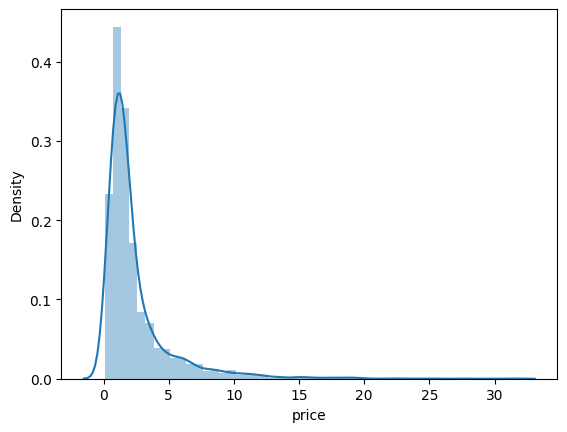

In [35]:
sns.distplot(y)

In [36]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

<ipython-input-37-aa92e888da11>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_transformed)


<Axes: xlabel='price', ylabel='Density'>

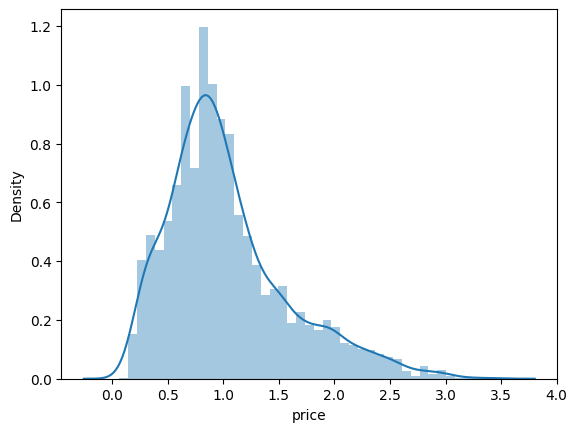

In [37]:
sns.distplot(y_transformed)

In [38]:
# Split the train and test
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2920, 13), (731, 13), (2920,), (731,))

In [40]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['built_up_area']),
        ('cat', OrdinalEncoder(), ['property_type']),
        ('cat1',OneHotEncoder(drop='first'),['sector','agePossession', 'balcony', 'furnishing_type', 'floor_category'])
    ],
    remainder='passthrough'
)

In [41]:
# Train and test each model
results = []
for name, model in models.items():
    pipeline, train_score, train_mae = train_and_score_model(model, X_train, y_train)
    mae, test_score = test_and_score_model(model, pipeline, X_test, y_test)
    results.append([name, train_score, train_mae, test_score, mae])

In [42]:
# Display results
columns = ['Model', 'Train R2', 'Train MAE', 'Test R2', 'Test MAE']
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

                Model  Train R2  Train MAE   Test R2  Test MAE
0   Linear Regression  0.850934   0.615773  0.686843  0.595538
1                 SVR  0.878384   0.451422  0.820173  0.487624
2               Ridge  0.851616   0.621191  0.691495  0.594451
3               Lasso -0.004127   1.541584 -0.034589  1.435635
4       Decision Tree  0.800071   0.003243  0.697041  0.586420
5       Random Forest  0.875814   0.202565  0.799228  0.509827
6         Extra Trees  0.886451   0.003243  0.820687  0.454903
7   Gradient Boosting  0.857109   0.539691  0.816639  0.569137
8            AdaBoost  0.735141   0.859989  0.689109  0.848176
9                 MLP  0.875971   0.189358  0.765295  0.518020
10            XGBoost  0.886132   0.250263  0.855423  0.445690


Observation : Contuning the future tuning with non feature selected data

OneHotEncoding With PCA

In [43]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['built_up_area']),
        ('cat', OrdinalEncoder(), ['property_type']),
        ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession', 'balcony', 'furnishing_type', 'floor_category'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', model)
])

# Creating a column transformer for preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
#         ('cat', OrdinalEncoder(), columns_to_encode),
#         ('cat1',OneHotEncoder(drop='first',sparse_output=False),['sector','agePossession'])
#     ],
#     remainder='passthrough'
# )

In [44]:
# Train and test each model
results = []
for name, model in models.items():
    pipeline, train_score, train_mae = train_and_score_model(model, X_train, y_train)
    mae, test_score = test_and_score_model(model, pipeline, X_test, y_test)
    results.append([name, train_score, train_mae, test_score, mae])

In [45]:
# Display results
columns = ['Model', 'Train R2', 'Train MAE', 'Test R2', 'Test MAE']
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

                Model  Train R2  Train MAE   Test R2  Test MAE
0   Linear Regression  0.850936   0.615773  0.686841  0.595536
1                 SVR  0.878384   0.451422  0.820173  0.487624
2               Ridge  0.851607   0.621291  0.690621  0.595012
3               Lasso -0.004127   1.541584 -0.034589  1.435635
4       Decision Tree  0.798810   0.003243  0.654166  0.606564
5       Random Forest  0.876512   0.202718  0.805948  0.501677
6         Extra Trees  0.887009   0.003243  0.815488  0.455183
7   Gradient Boosting  0.857513   0.539691  0.814405  0.569210
8            AdaBoost  0.734580   0.855864  0.675789  0.847587
9                 MLP  0.877908   0.267170  0.802296  0.498297
10            XGBoost  0.886132   0.250263  0.855423  0.445690


Target Encoder

In [46]:
!pip install category_encoders

In [47]:
import category_encoders as ce

# columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'floor_category']

# # Creating a column transformer for preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
#         ('cat', OrdinalEncoder(), columns_to_encode),
#         ('cat1',OneHotEncoder(drop='first',sparse_output=False),['agePossession']),
#         ('target_enc', ce.TargetEncoder(), ['sector'])
#     ],
#     remainder='passthrough'
# )

# Creating a column transformer for preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['built_up_area']),
        ('cat', OrdinalEncoder(), ['property_type']),
        ('cat1',OneHotEncoder(drop='first'),['agePossession', 'balcony', 'furnishing_type', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

In [48]:
# Train and test each model
results = []
for name, model in models.items():
    pipeline, train_score, train_mae = train_and_score_model(model, X_train, y_train)
    mae, test_score = test_and_score_model(model, pipeline, X_test, y_test)
    results.append([name, train_score, train_mae, test_score, mae])

In [49]:
# Display results
columns = ['Model', 'Train R2', 'Train MAE', 'Test R2', 'Test MAE']
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

                Model  Train R2  Train MAE   Test R2  Test MAE
0   Linear Regression  0.823298   0.698626  0.722686  0.649237
1                 SVR  0.856589   0.524397  0.796147  0.550921
2               Ridge  0.823343   0.698893  0.722305  0.649488
3               Lasso -0.004127   1.541584 -0.034589  1.435635
4       Decision Tree  0.814493   0.003243  0.635168  0.573137
5       Random Forest  0.890754   0.186984  0.836814  0.437994
6         Extra Trees  0.884694   0.003243  0.851479  0.440980
7   Gradient Boosting  0.876356   0.465729  0.856148  0.492260
8            AdaBoost  0.813505   0.705646  0.761316  0.683470
9                 MLP  0.849857   0.449708  0.695760  0.597948
10            XGBoost  0.888919   0.127989  0.842745  0.426584


Hyperparameter Tuning

Random Forest

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
# Define the parameter grid to search
param_grid = {
    'regressor__n_estimators': [25, 50, 75, 100, 125, 150],
    'regressor__max_depth': [None, 2, 4, 6 ],  # Set the max_depth parameter for the RandomForestRegressor
    'regressor__min_samples_split': [2, 4, 6],
    'regressor__max_samples': [ 0.7, 0.8],
    'regressor__max_features': ["auto", "log2"]
}

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['built_up_area', 'bathroom', 'bedRoom']),
        ('cat', OneHotEncoder(), ['property_type', 'agePossession', 'balcony', 'furnishing_type', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Fit the grid search to find the best parameters

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Train the pipeline with the best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)  # Already applied np.log1p to y_train

# Predict using the pipeline and inverse-transform the predictions
y_pred_train_tree = np.expm1(pipeline.predict(X_train))  # Predictions on the training set
y_pred_test_tree = np.expm1(pipeline.predict(X_test))    # Predictions on the test set

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [52]:
# Evaluate the pipeline
tree_mse_train = mean_squared_error(np.expm1(y_train), y_pred_train_tree)
tree_rmse_train = np.sqrt(tree_mse_train)
tree_r2_train = r2_score(np.expm1(y_train), y_pred_train_tree)
tree_mae_train = mean_absolute_error(np.expm1(y_train), y_pred_train_tree)


tree_mse_test = mean_squared_error(np.expm1(y_test), y_pred_test_tree)
tree_rmse_test = np.sqrt(tree_mse_test)
tree_r2_test = r2_score(np.expm1(y_test), y_pred_test_tree)
tree_mae_test = mean_absolute_error(np.expm1(y_test), y_pred_test_tree)


print("Tree Regressor Pipeline Training Results:")
print("Mean Squared Error (MSE):", tree_mse_train)
print("Root Mean Squared Error (RMSE):", tree_rmse_train)
print("R-squared (R2) Score:", tree_r2_train)
print("Mean Absolute Error (MAE):", tree_mae_train)

print("\nTree Regressor Pipeline Test Results:")
print("Mean Squared Error (MSE):", tree_mse_test)
print("Root Mean Squared Error (RMSE):", tree_rmse_test)
print("R-squared (R2) Score:", tree_r2_test)
print("Mean Absolute Error (MAE):", tree_mae_test)

# Tree Regressor Pipeline Training Results:
# Mean Squared Error (MSE): 0.3253450544756274
# Root Mean Squared Error (RMSE): 0.5703902650603597
# R-squared (R2) Score: 0.9579758058595296
# Mean Absolute Error (MAE): 0.22440689303344583

# Tree Regressor Pipeline Test Results:
# Mean Squared Error (MSE): 0.9349619024532315
# Root Mean Squared Error (RMSE): 0.9669342803175568
# R-squared (R2) Score: 0.8499277461870576
# Mean Absolute Error (MAE): 0.4277348596693034

Tree Regressor Pipeline Training Results:
Mean Squared Error (MSE): 0.30924408040533974
Root Mean Squared Error (RMSE): 0.5560971861152866
R-squared (R2) Score: 0.960055537673099
Mean Absolute Error (MAE): 0.22164800250523684

Tree Regressor Pipeline Test Results:
Mean Squared Error (MSE): 0.956838157197026
Root Mean Squared Error (RMSE): 0.9781810452043251
R-squared (R2) Score: 0.8464163530000486
Mean Absolute Error (MAE): 0.43335072571813593


In [53]:
import pickle

# Save the model
with open('random_forest_regressor_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

XGBoost (Extreme Gradient Boosting)

In [54]:
import xgboost as xgb

# Define additional parameters for XGBoost for tuning
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 2, 4, 6 ],
    'regressor__learning_rate': [0.001, 0.01, 0.1],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9]
}

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['built_up_area', 'bathroom', 'bedRoom']),
        ('cat', OneHotEncoder(), ['property_type', 'agePossession', 'balcony', 'furnishing_type', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor())  # Using XGBRegressor as the regressor
])

grid_search = GridSearchCV(pipeline, param_grid, cv=20, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Fit the grid search to find the best parameters

# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Train the pipeline with the best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)  # Already applied np.log1p to y_train

# Predict using the pipeline and inverse-transform the predictions
y_pred_train_xgb = np.expm1(pipeline.predict(X_train))  # Predictions on the training set
y_pred_test_xgb = np.expm1(pipeline.predict(X_test))    # Predictions on the test set

In [55]:
# Evaluate the pipeline
xgb_mse_train = mean_squared_error(np.expm1(y_train), y_pred_train_xgb)
xgb_rmse_train = np.sqrt(xgb_mse_train)
xgb_r2_train = r2_score(np.expm1(y_train), y_pred_train_xgb)
xgb_mae_train = mean_absolute_error(np.expm1(y_train), y_pred_train_xgb)


xgb_mse_test = mean_squared_error(np.expm1(y_test), y_pred_test_xgb)
xgb_rmse_test = np.sqrt(xgb_mse_test)
xgb_r2_test = r2_score(np.expm1(y_test), y_pred_test_xgb)
xgb_mae_test = mean_absolute_error(np.expm1(y_test), y_pred_test_xgb)


print("xgb Regressor Pipeline Training Results:")
print("Mean Squared Error (MSE):", xgb_mse_train)
print("Root Mean Squared Error (RMSE):", xgb_rmse_train)
print("R-squared (R2) Score:", xgb_r2_train)
print("Mean Absolute Error (MAE):", xgb_mae_train)

print("\nxgb Regressor Pipeline Test Results:")
print("Mean Squared Error (MSE):", xgb_mse_test)
print("Root Mean Squared Error (RMSE):", xgb_rmse_test)
print("R-squared (R2) Score:", xgb_r2_test)
print("Mean Absolute Error (MAE):", xgb_mae_test)


# xgb Regressor Pipeline Training Results:
# Mean Squared Error (MSE): 0.10514756850194484
# Root Mean Squared Error (RMSE): 0.3242646581142398
# R-squared (R2) Score: 0.9864182910687055
# Mean Absolute Error (MAE): 0.18604284320118492

# xgb Regressor Pipeline Test Results:
# Mean Squared Error (MSE): 0.8078474741334108
# Root Mean Squared Error (RMSE): 0.8988033567657672
# R-squared (R2) Score: 0.8703310895746813
# Mean Absolute Error (MAE): 0.4096051856284265

xgb Regressor Pipeline Training Results:
Mean Squared Error (MSE): 0.048646117162491224
Root Mean Squared Error (RMSE): 0.22055864789776713
R-squared (R2) Score: 0.9937164747283111
Mean Absolute Error (MAE): 0.13124167643865087

xgb Regressor Pipeline Test Results:
Mean Squared Error (MSE): 0.8699547153448679
Root Mean Squared Error (RMSE): 0.9327136298697837
R-squared (R2) Score: 0.8603621553943138
Mean Absolute Error (MAE): 0.41077512459699494


In [56]:
import pickle

# Save the model
with open('xbg_regressor_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

Exporting the model

In [58]:
# import pickle
# Load the model
with open('random_forest_regressor_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [59]:
# Load the model
with open('xbg_regressor_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

Trying out the predictions

In [60]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony', 'agePossession', 'built_up_area', 'study_room', 'servant_room', 'store_room', 'pooja_room', 'furnishing_type', 'floor_category'], dtype='object')

In [70]:
X.dtypes

property_type       object
sector              object
bedRoom            float64
bathroom           float64
balcony             object
agePossession       object
built_up_area      float64
study_room         float64
servant_room       float64
store_room         float64
pooja_room         float64
furnishing_type    float64
floor_category      object
dtype: object

In [61]:
X.iloc[0].values

array(['flat', 'sector 99a', 2.0, 1.0, '0', 'Relatively New', 500.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 'High Floor'], dtype=object)

In [72]:
data =   [['flat', 'sector 105', 2.0, 1.0, '0', 'Relatively New', 500.0, 0.0, 1.0, 0.0, 0.0, 0.0, 'High Floor']]
columns = ['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony', 'agePossession', 'built_up_area', 'study_room', 'servant_room', 'store_room', 'pooja_room', 'furnishing_type', 'floor_category']


# Convert to DataFrame
one_df = pd.DataFrame(data, columns=columns)

one_df

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,study_room,servant_room,store_room,pooja_room,furnishing_type,floor_category
0,flat,sector 105,2.0,1.0,0,Relatively New,500.0,0.0,1.0,0.0,0.0,0.0,High Floor


In [73]:
estimated_cost = np.expm1(rf_model.predict(one_df))[0]
formatted_cost = "{:.2f} Cr".format(estimated_cost)
print("The estimated cost of the house will be " + formatted_cost)

The estimated cost of the house will be 0.47 Cr


In [74]:
estimated_cost = np.expm1(xgb_model.predict(one_df))[0]
formatted_cost = "{:.2f} Cr".format(estimated_cost)
print("The estimated cost of the house will be " + formatted_cost)

The estimated cost of the house will be 0.41 Cr



Results : Finalizing the XGBoost (Extreme Gradient Boosting) model for the project aimed at forecasting non-parametric housing prices.

In [75]:
# sorted(X['sector'].unique().tolist())

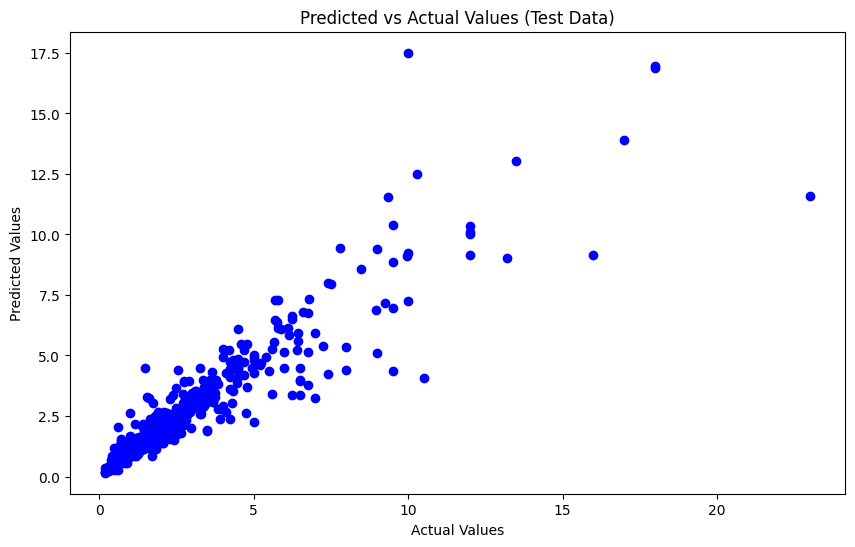

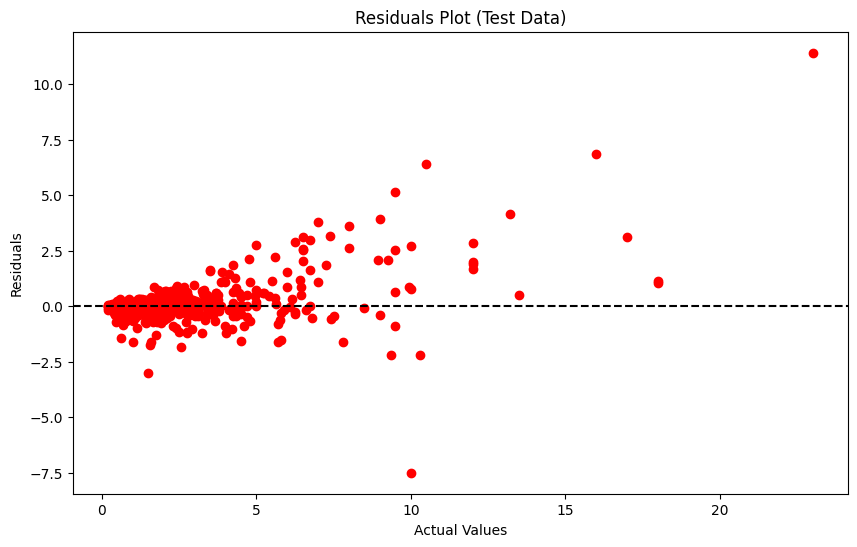

In [77]:
import matplotlib.pyplot as plt


# Predicted vs Actual Values Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), y_pred_test_xgb, color='blue')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Data) XGB')
plt.show()

# Residuals Plot
residuals = np.expm1(y_test) - y_pred_test_xgb
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y_test), residuals, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Test Data) XGB')
plt.show()